## Packages

In [1]:
import pandas as pd
import numpy as np
from math import ceil
## import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import sqlalchemy 
from sqlalchemy import create_engine, text

import sys
import os

## Add the path of the functions folder
current_dir = os.getcwd()  ## Gets the current working directory
sub_dir = os.path.abspath(os.path.join(current_dir, '..'
                                       , 'Functions'))
sys.path.append(sub_dir)

# Now you can import functions
from db_secrets import SQL_107

from visualisations import plot_prediction_error, plot_prediction_density_subplots

In [2]:
# TensorFlow sequential model
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


In [3]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

## Connection

In [4]:
## text for query
with open("../Exploratory_Analysis/111_sql.sql", "r") as file:
    query_text = file.read()

query_text = query_text.replace('REPLACE START DATE','2022-01-01')

In [5]:
## Create an engine + connection
engine = create_engine(SQL_107())
conn = engine.connect()

## Return data
df_raw = pd.read_sql(query_text,conn)

## Wrangle

In [6]:
## Makes working copy
df = df_raw.copy()

#df = df.sample(n=100000, random_state=42)

In [7]:
## List columns
df.columns

Index(['Start_Location', 'Call ID', 'Pseudo NHS Number', 'CallDate',
       'Call Connect Time', 'Weekday_Name', 'Week_Start', 'Financial Year',
       'Bank Holiday', 'In_Out_Hours', 'Sub ICB Code', 'Sub ICB Name',
       'GP Practice', 'GP Practice Code', 'GP Deprivation',
       'GP Survey Q21 Wait for Appt', 'Symptom_Group',
       'Final Disposition Code', 'Disposition Group', 'Disposition',
       'Call_Taker_Triages', 'Clinical_Triages', 'Patient Age', 'Patient Sex',
       'Outcome ID', 'Outcome Datetime', 'Outcome Type', 'Outcome',
       'Outcome Location Code', 'Outcome Location Name', 'Hours to Outcome'],
      dtype='object')

In [8]:
df = df[['Call Connect Time'
         ,'Bank Holiday'
         , 'In_Out_Hours'
         , 'Sub ICB Name'
         ,'Outcome Type']].copy()

#### binary outcome

In [9]:
df['Calls'] = 1

In [10]:
df['Outcome'] = df['Outcome Type'].transform(lambda x: 0 if x == 'No UEC Contact' else 1)
df = df.drop(['Outcome Type'],axis=1) 

In [11]:
timestamp_s = df['Call Connect Time'].map(pd.Timestamp.timestamp)


In [12]:
df['Call Connect Time'].dt.day_of_year

0            4
1            4
2            4
3            4
4            4
          ... 
2431476    302
2431477    302
2431478    302
2431479    302
2431480    302
Name: Call Connect Time, Length: 2431481, dtype: int32

In [13]:
## Date time conversion to numeric
df['year']    = df['Call Connect Time'].dt.year

df['month sin'] = np.sin(df['Call Connect Time'].dt.month * (2*np.pi/12))
df['month cos'] = np.cos(df['Call Connect Time'].dt.month * (2*np.pi/12))

df['YearDay sin'] = np.sin(df['Call Connect Time'].dt.day_of_year * (2*np.pi/365))
df['YearDay cos'] = np.cos(df['Call Connect Time'].dt.day_of_year * (2*np.pi/365))

df['weekday sin'] = np.sin(df['Call Connect Time'].dt.weekday+1 * (2*np.pi/7))  # Monday=0, Sunday=6
df['weekday cos'] = np.cos(df['Call Connect Time'].dt.weekday+1 * (2*np.pi/7))  # Monday=0, Sunday=6

df['Hour sin'] = np.sin(df['Call Connect Time'].dt.hour * (2*np.pi/24))
df['Hour cos'] = np.cos(df['Call Connect Time'].dt.hour * (2*np.pi/24))

df = df.drop('Call Connect Time',axis=1) 

#### Aggregates count 

In [14]:
df = df.groupby([ 'year'
         , 'month sin'
         , 'month cos'
         , 'YearDay sin'
         , 'YearDay cos'
         , 'weekday sin'
         , 'weekday cos'
         , 'Hour sin'
         , 'Hour cos'
         , 'Bank Holiday'
         , 'In_Out_Hours'
         , 'Sub ICB Name']).agg('sum').reset_index()

In [15]:
## One hot encodinng for boolean variables
bool_mapping = {
    'Yes': 1,
    'No': 0,
    'In Hours': 1,
    'Out of Hours': 0
}

df.loc[:,'Is Bank Holiday'] = df['Bank Holiday'].map(bool_mapping)             
df.loc[:,'In Hours'] = df['In_Out_Hours'].map(bool_mapping)
df = df.drop(['Bank Holiday','In_Out_Hours'],axis=1) 

In [16]:
## Dummy variables from ICB
df = pd.concat([df, pd.get_dummies(df['Sub ICB Name']
                                   ,dtype=int
                                   , prefix='SubICB')]
                ,axis=1)
df = df.drop('Sub ICB Name', axis=1)

In [17]:
df.head()

,year,month sin,month cos,YearDay sin,YearDay cos,weekday sin,weekday cos,Hour sin,Hour cos,Calls,Outcome,Is Bank Holiday,In Hours,SubICB_County Durham,SubICB_Newcastle Gateshead,SubICB_North Tyneside,SubICB_Northumberland,SubICB_South Tyneside,SubICB_Sunderland,SubICB_Tees Valley
0,2022,-1.0,-1.836970e-16,-0.999917,-0.01291,-0.982898,0.184152,-1.0,-1.836970e-16,34,12,0,0,1,0,0,0,0,0,0
1,2022,-1.0,-1.836970e-16,-0.999917,-0.01291,-0.982898,0.184152,-1.0,-1.836970e-16,25,5,0,0,0,1,0,0,0,0,0
2,2022,-1.0,-1.836970e-16,-0.999917,-0.01291,-0.982898,0.184152,-1.0,-1.836970e-16,10,3,0,0,0,0,1,0,0,0,0
3,2022,-1.0,-1.836970e-16,-0.999917,-0.01291,-0.982898,0.184152,-1.0,-1.836970e-16,15,5,0,0,0,0,0,1,0,0,0
4,2022,-1.0,-1.836970e-16,-0.999917,-0.01291,-0.982898,0.184152,-1.0,-1.836970e-16,6,2,0,0,0,0,0,0,1,0,0


## Build a baseline mode

Baseline split

In [18]:
base_X = df.drop('Outcome',axis=1)# X = all  except the 'Outcome' column
base_y = df['Outcome']# y = 'Outcome' column 

base_X_train, base_X_test, base_y_train, base_y_test = train_test_split(base_X
                                                    , base_y 
                                                    , test_size = 0.25
                                                    , random_state=42)

In [19]:
## Joins outcome onto predictors
base_df = pd.concat([base_X_train,base_y_train],axis=1)

In [20]:
## Columns we care about for baseline model
group_cols = [
    'month sin'
    ,'month cos'    
    ,'weekday sin'
    ,'weekday cos'
    ,'Hour sin'
    ,'Hour cos'
    ,'SubICB_County Durham'
    ,'SubICB_Newcastle Gateshead'
    ,'SubICB_North Tyneside'
    ,'SubICB_Northumberland'
    ,'SubICB_South Tyneside'
    ,'SubICB_Sunderland'
    ,'SubICB_Tees Valley'
]

## Mean value across baseline
base_trained = (base_df[group_cols + ['Outcome']]
                .groupby(group_cols)
                .agg( Pred_Outcome=pd.NamedAgg(column="Outcome"
                                               , aggfunc="mean"))
                )





In [21]:
base_y_pred_train = pd.merge(base_X_train,base_trained,how='left',on=group_cols)['Pred_Outcome']
base_y_pred_test = pd.merge(base_X_test,base_trained,how='left',on=group_cols)['Pred_Outcome']

In [22]:
def calculate_baseline_accuracy(y_pred_train,y_pred_test,y_train, y_test):
    """Calculate and print accuracy of training and test data fits"""    

    # Calculate Mean Absolute Error (MAE) for training and test sets
    mae_train = np.mean(np.abs(y_pred_train - y_train))
    mae_test = np.mean(np.abs(y_pred_test - y_test))
    
    # Calculate Mean Squared Error (MSE) for training and test sets
    mse_train = np.mean((y_pred_train - y_train) ** 2)
    mse_test = np.mean((y_pred_test - y_test) ** 2)

    # Print the results
    print(f'Training MAE: {mae_train:.3f}')
    print(f'Test MAE: {mae_test:.3f}')
    print(f'Training MSE: {mse_train:.3f}')
    print(f'Test MSE: {mse_test:.3f}')

## Split

In [23]:
X = df.drop('Outcome',axis=1).to_numpy() # X = all  except the 'Outcome' column
y = df['Outcome'].to_numpy() # y = 'Outcome' column 


X_train, X_test, y_train, y_test = train_test_split(X
                                                    , y 
                                                    , test_size = 0.25
                                                    , random_state=42)

## Scale

In [24]:
def scale_data(Xy_train, Xy_test,X_or_y = ['X','y']):
    """Scale data 0-1 based on min and max in training set"""
    
    # Initialise a new scaling object for normalising input data
    sc = MinMaxScaler()
    
    if X_or_y == 'X':
        # Apply the scaler to the training and test sets
        train_sc = sc.fit_transform(Xy_train)
        test_sc = sc.transform(Xy_test)

    elif X_or_y == 'y':
        # Apply the scaler to the training and test sets
        train_sc = sc.fit_transform(Xy_train.reshape(-1, 1))
        test_sc = sc.transform(Xy_test.reshape(-1, 1))        
        
    return train_sc, test_sc

In [25]:
# Scale X data
X_train, X_test = scale_data(X_train, X_test, X_or_y='X')


# Scale y data
#y_train, y_test = scale_data(y_train, y_test, X_or_y='y')

## Build a model

In [26]:
def make_net(number_features, 
             hidden_layers=3, 
             hidden_layer_neurones=128, 
             dropout=0.0, 
             learning_rate=0.003):
    
    """Make TensorFlow neural net"""
    
    # Clear Tensorflow 
    K.clear_session()
    
    # Set up neural net
    net = Sequential()
    
    # Add hidden hidden_layers using a loop
    for i in range(hidden_layers):
        # Add fully connected layer with ReLu activation
        net.add(Dense(
            hidden_layer_neurones, 
            input_dim=number_features,
            activation='relu'))
        # Add droput layer
        net.add(Dropout(dropout))
    
    # Add final sigmoid activation output
    net.add(Dense(1, activation='linear'))    
    #    net.add(Dense(1, activation='sigmoid'))    

    # Compiling model
    opt = Adam(learning_rate=learning_rate)
    
    net.compile(loss='mse', 
                optimizer=opt, 
                metrics=['mae'])
    
    return net

In [27]:
def calculate_accuracy(model, X_train_sc, X_test_sc, y_train, y_test):
    """Calculate and print accuracy of training and test data fits"""    
    
   # Predict on training and test data
    y_pred_train = model.predict(X_train_sc).flatten()
    y_pred_test = model.predict(X_test_sc).flatten()

    # Calculate Mean Absolute Error (MAE) for training and test sets
    mae_train = np.mean(np.abs(y_pred_train - y_train))
    mae_test = np.mean(np.abs(y_pred_test - y_test))
    
    # Calculate Mean Squared Error (MSE) for training and test sets
    mse_train = np.mean((y_pred_train - y_train) ** 2)
    mse_test = np.mean((y_pred_test - y_test) ** 2)

    # Print the results
    print(f'Training MAE: {mae_train:.3f}')
    print(f'Test MAE: {mae_test:.3f}')
    print(f'Training MSE: {mse_train:.3f}')
    print(f'Test MSE: {mse_test:.3f}')

In [28]:
def plot_training(history_dict,measure='mae'):
    acc_values = history_dict[measure]
    val_acc_values = history_dict[f'val_{measure}']
    epochs = range(1, len(acc_values) + 1)

    fig, ax = plt.subplots()

    ax.set_xlabel('Time')
    ax.set_ylabel(measure)

    ax.plot(epochs, acc_values, color='blue', label=f'Training {measure}')
    ax.plot(epochs, val_acc_values, color='red', label=f'Test {measure}')
    ax.set_title(f'Training and validation {measure}')
    
    ax.legend()

    fig.show()

In [29]:
model = make_net(number_features=X_train.shape[1], 
             hidden_layers=3, 
             hidden_layer_neurones=128, 
             dropout=0.10, 
             learning_rate=0.003)

In [30]:
# Define save checkpoint callback (only save if new best validation results)
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    'model_checkpoint.keras', save_best_only=True)

# Define early stopping callback
# Stop when no validation improvement for 25 epochs
# Restore weights to best validation accuracy
early_stopping_cb_loss = keras.callbacks.EarlyStopping(
    patience=20, restore_best_weights=True, monitor='val_loss')

#early_stopping_cb_acc = keras.callbacks.EarlyStopping(
#    patience=5, restore_best_weights=True, monitor='val_accuracy')


### Train model (and store training info in history)
history = model.fit(X_train,
                    y_train,
                    epochs=200,
                    batch_size=64,
                    validation_data=(X_test, y_test),
                    verbose=1,
                    callbacks=[checkpoint_cb
                               , early_stopping_cb_loss
                               #, early_stopping_cb_acc
                               ])

Epoch 1/200
1992/1992 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 5.9010 - mae: 1.6903 - val_loss: 3.7415 - val_mae: 1.3902
Epoch 2/200
1992/1992 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 3.8981 - mae: 1.4255 - val_loss: 3.7605 - val_mae: 1.4641
Epoch 3/200
1992/1992 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 3.8422 - mae: 1.4120 - val_loss: 3.4749 - val_mae: 1.3627
Epoch 4/200
1992/1992 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 3.7845 - mae: 1.4021 - val_loss: 3.4956 - val_mae: 1.3500
Epoch 5/200
1992/1992 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 3.7668 - mae: 1.3949 - val_loss: 3.8374 - val_mae: 1.3854
Epoch 6/200
1992/1992 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 3.7433 - mae: 1.3953 - val_loss: 3.3942 - val_mae: 1.3526
Epoch 7/200
1992/1992 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 3.7223 - mae: 1.3947 - val_loss: 3.3759 - val_mae: 1.3325
Epoch 8/200
1992/1992 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 3.6436 - mae: 1.3798 - val_loss: 3.3992 - val_mae: 1.3547
Epoch 9/200
1992/1992 ━━━━━━━━━━

## Accuracy

In [31]:
## Baseline accuracy is the mean of site, month, weekday, hour
calculate_baseline_accuracy(base_y_pred_train
                            ,base_y_pred_test
                            ,base_y_train
                            ,base_y_test)


Training MAE: 4.204
Test MAE: 3.993
Training MSE: 36.884
Test MSE: 32.834


In [32]:
calculate_accuracy(model, X_train, X_test, y_train, y_test)

3984/3984 ━━━━━━━━━━━━━━━━━━━━ 3s 775us/step
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 1s 772us/step
Training MAE: 1.330
Test MAE: 1.330
Training MSE: 3.289
Test MSE: 3.301


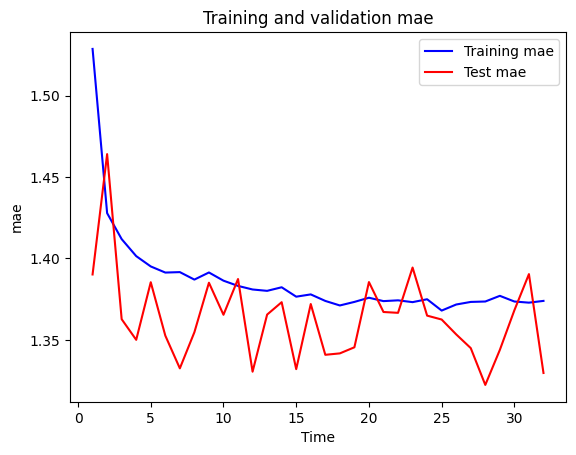

In [33]:
plot_training(history.history,measure='mae')

3984/3984 ━━━━━━━━━━━━━━━━━━━━ 3s 801us/step
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 1s 731us/step


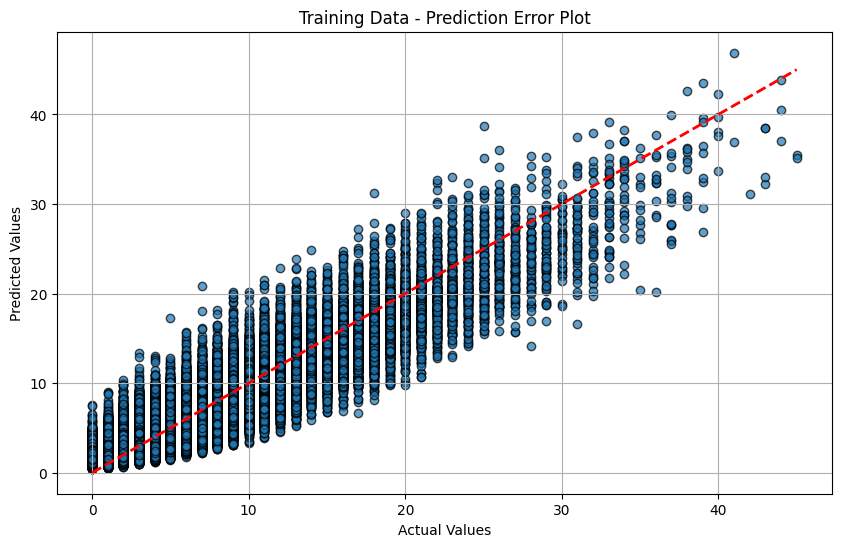

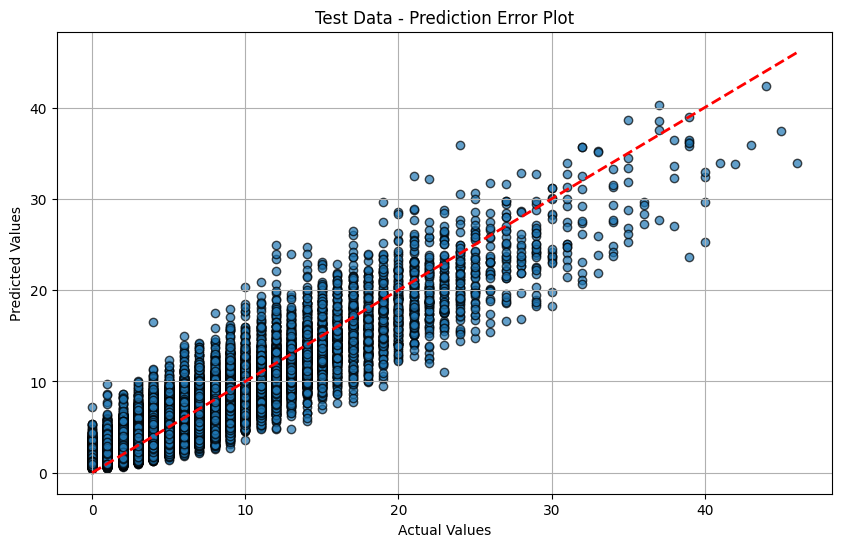

In [ ]:
# Generate predictions
y_pred_train = model.predict(X_train).flatten()
y_pred_test = model.predict(X_test).flatten()

# Plot errors for both training and test data
plot_prediction_error(y_train, y_pred_train, title='Training Data - Prediction Error Plot')
plot_prediction_error(y_test, y_pred_test, title='Test Data - Prediction Error Plot')

3984/3984 ━━━━━━━━━━━━━━━━━━━━ 3s 813us/step
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 1s 769us/step


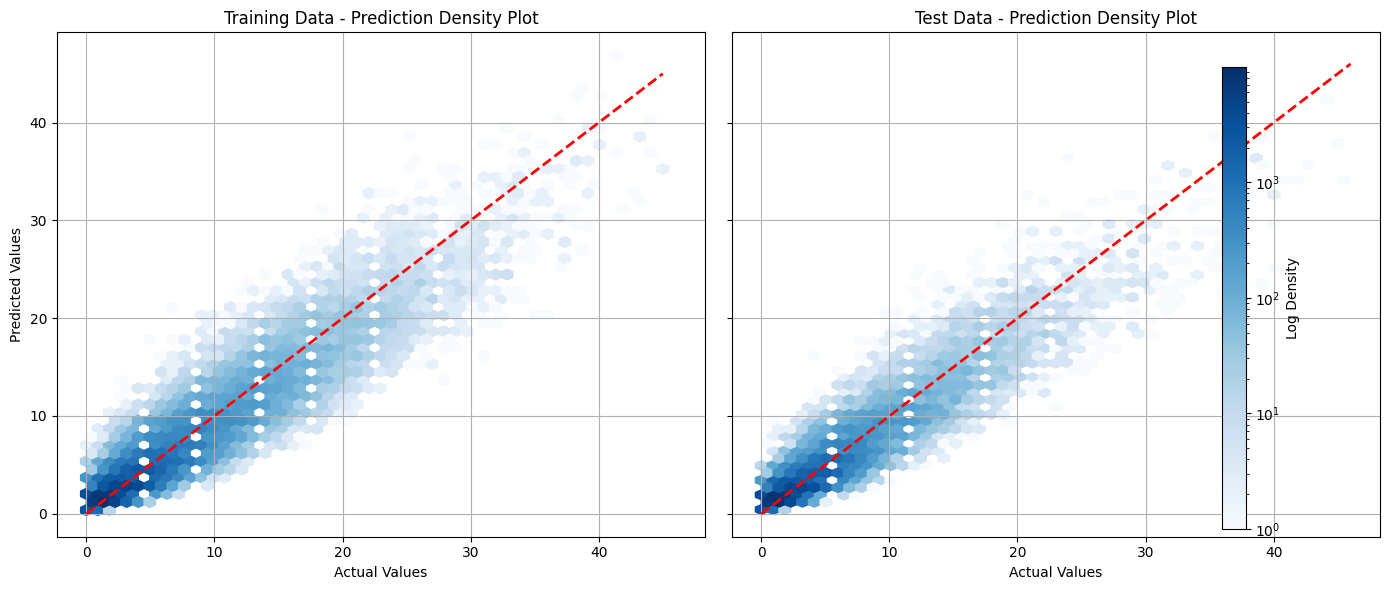

In [ ]:
# Generate predictions
y_pred_train = model.predict(X_train).flatten()
y_pred_test = model.predict(X_test).flatten()

# Plot the density plots as subplots
plot_prediction_density_subplots(y_train, y_pred_train, y_test, y_pred_test)


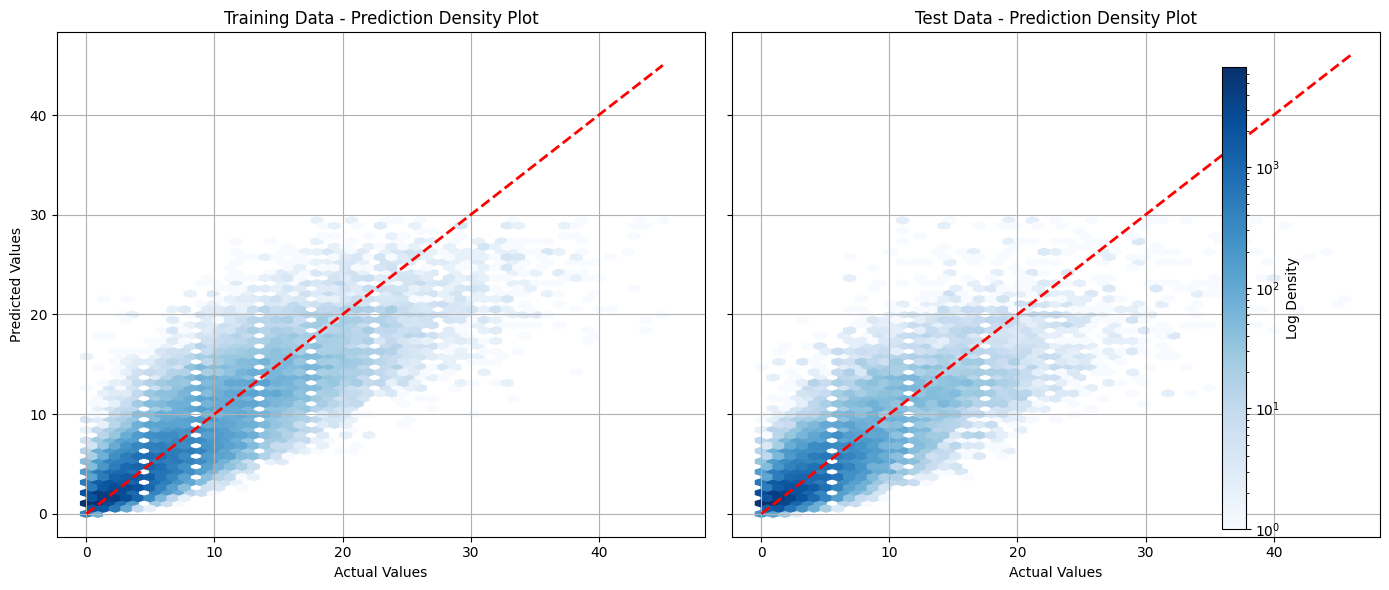

In [36]:
plot_prediction_density_subplots(base_y_train
                                 , base_y_pred_train
                                 , base_y_test
                                 , base_y_pred_test)